In [1]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# 1 - create engine:
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [2]:
query = """
SELECT *
FROM fact_neighborhood_price_analysis;
"""

df = pd.read_sql(query, engine)

df.head()

,neighborhood,price_2025,crime_count,distinct_offence_count,library_count,school_count,school_type_count,restaurant_count,park_count,park_type_count,station_count,total_entrances,total_routes,avg_fine_particles,avg_no2
0,Annadale,802312.506539,48,14,0,1,1,3,5,2,0,0.0,0.0,6.181404,11.320946
1,Arden Heights,534218.504946,32,14,0,0,0,0,2,1,0,0.0,0.0,6.181404,11.320946
2,Arrochar,755560.793354,203,22,1,2,1,0,2,2,0,0.0,0.0,6.119536,10.464431
3,Astoria,743956.755533,2927,44,3,13,5,314,16,5,4,15.0,8.0,7.254344,18.410157
4,Bath Beach,792107.819036,1904,35,1,4,3,26,5,4,3,11.0,3.0,6.474938,16.388280


In [3]:
print(len(df))

197


#### Data preparation for clustering:


In [4]:
# remove identifier column (target)
df_model = df.drop(columns=["neighborhood"])

In [5]:
# check nulls 
df_model.isnull().sum()

price_2025                 0
crime_count                0
distinct_offence_count     0
library_count              0
school_count               0
school_type_count          0
restaurant_count           0
park_count                 0
park_type_count            0
station_count              0
total_entrances            0
total_routes               0
avg_fine_particles        61
avg_no2                   61
dtype: int64

In [6]:
# fill NaNs in air quality columns with column means
for col in ["avg_fine_particles", "avg_no2"]:
    df_model[col].fillna(df_model[col].mean(), inplace=True)

# verify
df_model[["avg_fine_particles", "avg_no2"]].isnull().sum()

C:\Users\tiakh\AppData\Local\Temp\ipykernel_11552\834308049.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(df_model[col].mean(), inplace=True)


avg_fine_particles    0
avg_no2               0
dtype: int64

In [7]:
# SCALE FEATURES:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

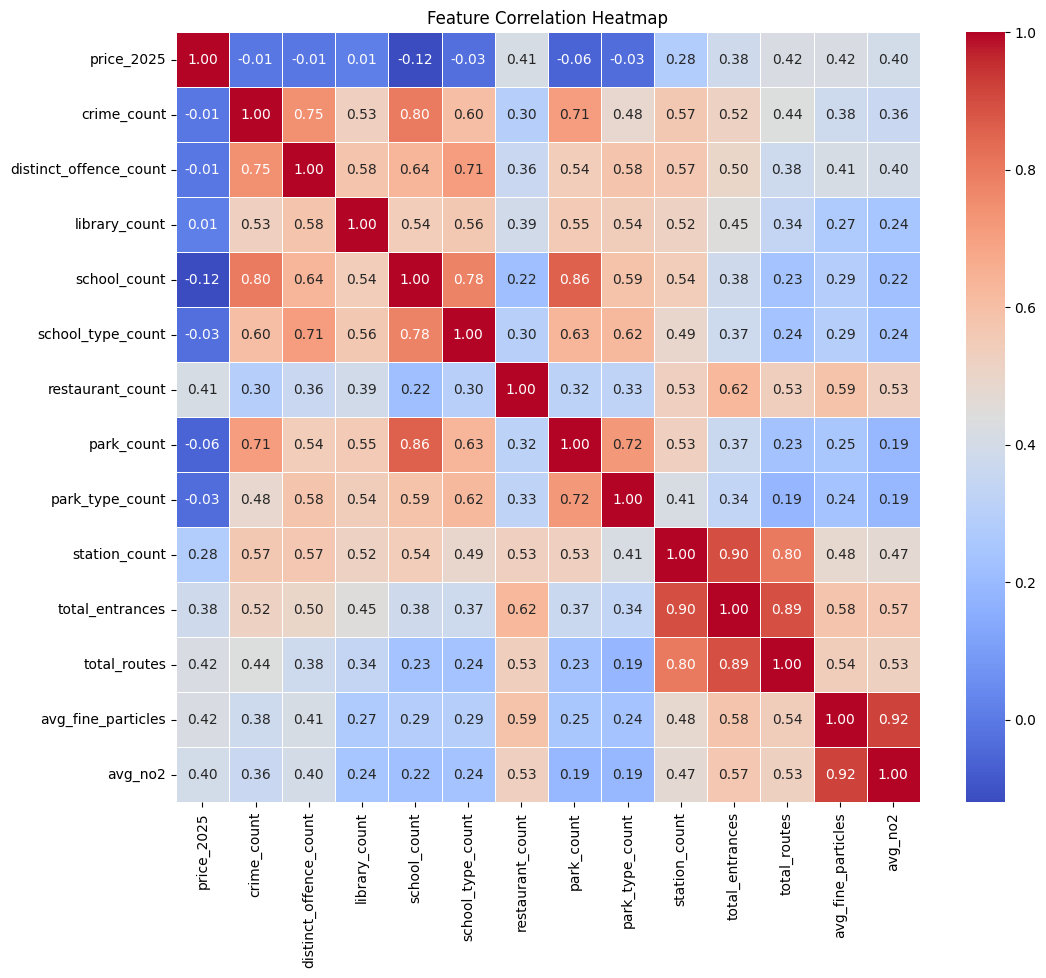

In [8]:
# heatmap:
corr = df_model.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

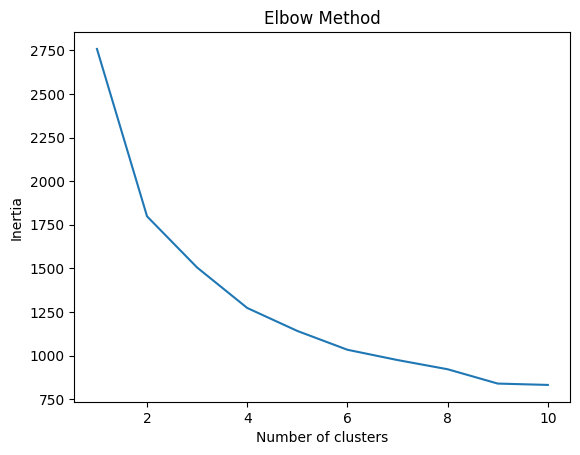

In [9]:
# Elbow method to choose number of clusters:

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [10]:
# KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters

In [11]:
# quick check:
df["cluster"].value_counts()

cluster
0    82
2    76
1    28
3    11
Name: count, dtype: int64

In [12]:
df.groupby(["cluster", "neighborhood"]).mean()

price_2025  crime_count  distinct_offence_count  \
cluster neighborhood                                                        
0       Annadale        8.023125e+05         48.0                    14.0   
        Arden Heights   5.342185e+05         32.0                    14.0   
        Arrochar        7.555608e+05        203.0                    22.0   
        Bay Terrace     6.750030e+05         38.0                    14.0   
        Belle Harbor    1.042743e+06         19.0                     9.0   
...                              ...          ...                     ...   
3       Longwood        5.050524e+05       5321.0                    48.0   
        Melrose         5.553119e+05       8328.0                    50.0   
        Morris Heights  5.823283e+05       4585.0                    44.0   
        Mott Haven      7.673328e+05       4292.0                    45.0   
        Tremont         4.460472e+05       8201.0                    47.0   

                        library_count  school_count  school_type_count  \
cluster neighborhood                                                     
0       Annadale                  0.0           1.0                1.0   
        Arden Heights             0.0           0.0                0.0   
        Arrochar                  1.0           2.0                1.0   
        Bay Terrace               0.0           1.0                1.0   
        Belle Harbor              0.0           1.0                1.0   
...                               ...           ...                ...   
3       Longwood                  2.0          60.0                8.0   
        Melrose                   1.0          60.0                7.0   
        Morris Heights            2.0          32.0                6.0   
        Mott Haven                1.0          35.0                5.0   
        Tremont                   3.0          47.0                5.0   

                        restaurant_count  park_count  park_type_count  \
cluster neighborhood                                                    
0       Annadale                     3.0         5.0              2.0   
        Arden Heights                0.0         2.0              1.0   
        Arrochar                     0.0         2.0              2.0   
        Bay Terrace                  3.0         2.0              2.0   
        Belle Harbor                 4.0         2.0              2.0   
...                                  ...         ...              ...   
3       Longwood                    31.0        34.0              8.0   
        Melrose                     31.0        39.0              6.0   
        Morris Heights              30.0        23.0             10.0   
        Mott Haven                  35.0        21.0              9.0   
        Tremont                     23.0        31.0              7.0   

                        station_count  total_entrances  total_routes  \
cluster neighborhood                                                   
0       Annadale                  0.0              0.0           0.0   
        Arden Heights             0.0              0.0           0.0   
        Arrochar                  0.0              0.0           0.0   
        Bay Terrace               0.0              0.0           0.0   
        Belle Harbor              0.0              0.0           0.0   
...                               ...              ...           ...   
3       Longwood                  8.0             30.0          12.0   
        Melrose                   2.0             11.0           4.0   
        Morris Heights            4.0             11.0           4.0   
        Mott Haven                4.0             19.0           4.0   
        Tremont                   5.0             20.0           8.0   

                        avg_fine_particles    avg_no2  
cluster neighborhood                                   
0       Annadale                  6.181404  11.320946  
      

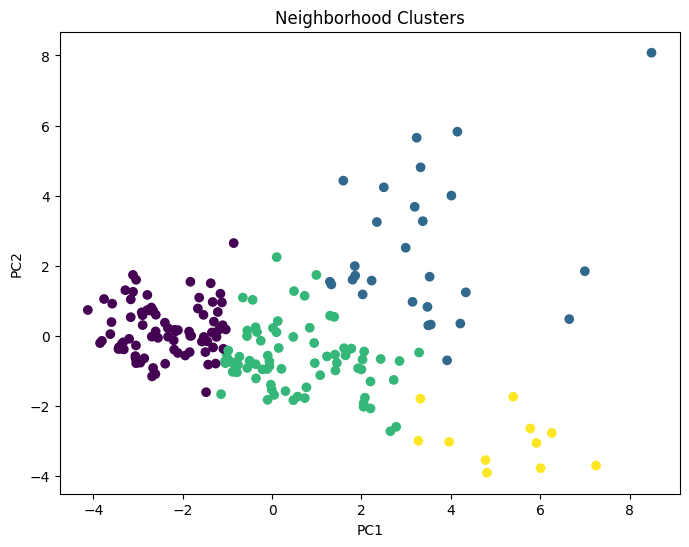

In [13]:
# visualizations:
 
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], c=df["cluster"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Neighborhood Clusters")
plt.show()

In [ ]:
df.head()

,neighborhood,price_2025,crime_count,distinct_offence_count,library_count,school_count,school_type_count,restaurant_count,park_count,park_type_count,station_count,total_entrances,total_routes,avg_fine_particles,avg_no2,cluster
0,Annadale,802312.506539,48,14,0,1,1,3,5,2,0,0.0,0.0,6.181404,11.320946,0
1,Arden Heights,534218.504946,32,14,0,0,0,0,2,1,0,0.0,0.0,6.181404,11.320946,0
2,Arrochar,755560.793354,203,22,1,2,1,0,2,2,0,0.0,0.0,6.119536,10.464431,0
3,Astoria,743956.755533,2927,44,3,13,5,314,16,5,4,15.0,8.0,7.254344,18.410157,1
4,Bath Beach,792107.819036,1904,35,1,4,3,26,5,4,3,11.0,3.0,6.474938,16.388280,2


In [16]:
cols_to_keep = ["neighborhood", "cluster"]

In [17]:
df = df[cols_to_keep]

In [18]:
# Send df to PostgreSQL
df.to_sql('clusters', engine, if_exists='replace', index=False)


197